# [INFO-H515 - Big Data Scalable Analytics](http://uv.ulb.ac.be/course/view.php?id=74317?username=guest)


## TP 5 - Convolution Nets for MNIST

#### *Yann-Aël Le Borgne, Jacopo De Stefani and Gianluca Bontempi*

####  16/05/2018

### Credits

Notebook content adapted from

* Jason Brownlee. *[Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras](https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)*. https://machinelearningmastery.com. Last accessed: 14/05/2018.
* Valerio Maggio. *[deep-learning-keras-tensorflow/4. Convolutional Neural Networks/4.2. MNIST CNN.ipynb](https://github.com/leriomaggio/deep-learning-keras-tensorflow/blob/master/4.%20Convolutional%20Neural%20Networks/4.2.%20MNIST%20CNN.ipynb)*. https://github.com/leriomaggio. Last accessed: 14/05/2018.

## Class summary

A popular demonstration of the capability of deep learning techniques is object recognition in image data.

The “hello world” of object recognition for machine learning and deep learning is the MNIST dataset for **handwritten digit recognition**.

In this class you will discover how to develop a deep learning model to achieve near state of the art performance on the MNIST handwritten digit recognition task in Python using the Keras deep learning library.


### Class objectives:

* How to load the MNIST dataset in Keras.
* How to develop and evaluate a baseline neural network model for the MNIST problem.
* How to implement and evaluate a simple Convolutional Neural Network for MNIST.
* How to implement a close to state-of-the-art deep learning model for MNIST.

### Documentation

See https://keras.io

In particular, look at:
* Sequential model guide: https://keras.io/getting-started/sequential-model-guide/
* Convolutional layers: https://keras.io/layers/convolutional/
* Gradient descent algorithms: https://keras.io/optimizers/. See http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html and https://github.com/mazefeng/sgd-opt for more qualitative details and illustrations.


## Dataset description

The MNIST problem is a dataset developed by Yann LeCun, Corinna Cortes and Christopher Burges for evaluating machine learning models on the handwritten digit classification problem.

The dataset was constructed from a number of scanned document dataset available from the National Institute of Standards and Technology (NIST). This is where the name for the dataset comes from, as the Modified NIST or MNIST dataset.

Images of digits were taken from a variety of scanned documents, normalized in size and centered. This makes it an excellent dataset for evaluating models, allowing the developer to focus on the machine learning with very little data cleaning or preparation required.

Each image is a 28 by 28 pixel square (784 pixels total). A standard split of the dataset is used to evaluate and compare models, where 60,000 images are used to train a model and a separate set of 10,000 images are used to test it.

It is a digit recognition task. As such there are 10 digits (0 to 9) or 10 classes to predict. Results are reported using prediction error, which is nothing more than the inverted classification accuracy.

Excellent results achieve a prediction error of less than 1%. State-of-the-art prediction error of approximately 0.2% can be achieved with large Convolutional Neural Networks. There is a listing of the state-of-the-art results and links to the relevant papers on the MNIST and other datasets on [Rodrigo Benenson’s webpage](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354).

## General imports

In [1]:
#Import the required libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.random.seed(1338)

from keras.datasets import mnist

%matplotlib inline
import matplotlib.pyplot as plt

Using Theano backend.


## Loading the MNIST dataset in Keras

To load the MNIST dataset, we can use the `load_data()` function provided by the Keras deep learning library. This function automatically downloads and stores the dataset in your home directory in ~/.keras/datasets/mnist.npz as a 15MB file. It is very handy for developing and testing deep learning models.

To demonstrate how easy it is to load the MNIST dataset, we will first write a little script to download and visualize the first 16 images in the training dataset.

In [30]:
from keras.datasets import mnist

# load (downloaded if needed) the MNIST dataset
(X_train_all, y_train_all), (X_test_all, y_test_all) = mnist.load_data()

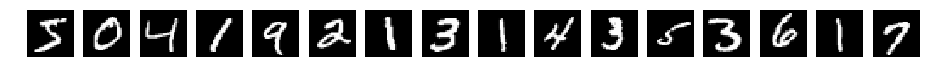

In [20]:
# plot 16 images as gray scale
nb_images = 16

plt.figure(figsize=(16,8))
for i in range(nb_images):
    plt.subplot(1, nb_images, i+1)
    plt.imshow(X_train_all[i], interpolation='nearest',cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [31]:
#For speeding up execution times in this class, let us take a subset of the dataset 
X_train=X_train_all[0:2000]
y_train=y_train_all[0:2000]
X_test=X_test_all[0:1000]
y_test=y_test_all[0:1000]

# Baseline Model with Multi-Layer Perceptrons

Do we really need a complex model like a convolutional neural network to get the best results with MNIST?

You can get very good results using a very simple neural network model with a single hidden layer. In this section we will create a simple multi-layer perceptron model that achieves an error rate of 10%. We will use this as a baseline for comparing more complex convolutional neural network models.

Let’s start off by importing the classes and functions we will need.

In [12]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

#For visualising accuracy estimates
from livelossplot import PlotLossesKeras

It is always a good idea to initialize the random number generator to a constant to ensure that the results of your script are reproducible.

In [13]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [32]:
X_train.shape

(2000, 28, 28)

In [33]:
y_train.shape

(2000,)

The training dataset is structured as a 3-dimensional array of: number of instances, image width and image height. For a multi-layer perceptron model, we must reduce each 2D image to a vector of pixels. In this case, for each 28×28 sized image, we'll use the corresponding 784 pixels vector as input.

We can do this transform easily using the `reshape()` function on the NumPy array. We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway.

In [34]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [35]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

Finally, the output variable is an integer from 0 to 9. This is a multi-class classification problem. As such, it is good practice to use a one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in `np_utils.to_categorical()` helper function in Keras.

In [36]:
# one hot encode outputs
print("Before:")
print(y_train[0])
print(y_train.shape)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]
print("After:")
print(y_train[0])
print(y_train.shape)

5
(2000,)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(2000, 10)


We are now ready to create our simple neural network model. We will define our model in a function. This is handy if you want to extend the example later and try and get a better score.

In [70]:
num_dense_layers = 1

# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    for l in range(num_dense_layers):   
        model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

The model is a simple neural network with one hidden layer with the same number of neurons as there are inputs (784). A rectifier activation function (`relu`, rectified linear unit) is used for the neurons in the hidden layer.

A softmax activation function is used on the output layer to turn the outputs into probability-like values, and allow one of the 10 classes to be selected as the model’s output prediction. Logarithmic loss is used as the loss function (called `categorical_crossentropy` in Keras) and the efficient ADAM gradient descent algorithm (`optimizer='adam'`) is used to learn the weights.



In [71]:
# build the model
model = baseline_model()

**Exercise**

* Why was `relu` activation function used in the first layer, and the `softmax` in the second layer? What other activation functions could be used?
* Why was the `kernel_initializer` set to 'normal' and not zeros?
* What is the number of parameters in this network? Come up with your estimate, and use the `model.summary()` function to check your result

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_14 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_15 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                7850      
Total params: 1,854,170
Trainable params: 1,854,170
Non-trainable params: 0
_________________________________________________________________


We can now fit and evaluate the model. The model is fit over 10 epochs with updates every 100 images. The test data is used as the validation dataset, allowing you to see the skill of the model as it trains. A verbose value of 2 is used to reduce the output to one line for each training epoch.

Finally, the test dataset is used to evaluate the model and a classification error rate is printed.

In [80]:

epochs=10
batch_size=100 # 128, 256

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, verbose=2)

# prints the loss and accuracy throughout epochs
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, verbose=2, callbacks=[PlotLossesKeras()])

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))


Train on 2000 samples, validate on 1000 samples
Epoch 1/10
 - 0s - loss: 4.4264e-04 - acc: 1.0000 - val_loss: 0.3542 - val_acc: 0.9110
Epoch 2/10
 - 0s - loss: 4.3695e-04 - acc: 1.0000 - val_loss: 0.3548 - val_acc: 0.9110
Epoch 3/10
 - 0s - loss: 4.3107e-04 - acc: 1.0000 - val_loss: 0.3554 - val_acc: 0.9110
Epoch 4/10
 - 0s - loss: 4.2596e-04 - acc: 1.0000 - val_loss: 0.3558 - val_acc: 0.9110
Epoch 5/10
 - 0s - loss: 4.2032e-04 - acc: 1.0000 - val_loss: 0.3563 - val_acc: 0.9120
Epoch 6/10
 - 0s - loss: 4.1523e-04 - acc: 1.0000 - val_loss: 0.3567 - val_acc: 0.9120
Epoch 7/10
 - 0s - loss: 4.0981e-04 - acc: 1.0000 - val_loss: 0.3572 - val_acc: 0.9120
Epoch 8/10
 - 0s - loss: 4.0490e-04 - acc: 1.0000 - val_loss: 0.3577 - val_acc: 0.9120
Epoch 9/10
 - 0s - loss: 4.0007e-04 - acc: 1.0000 - val_loss: 0.3577 - val_acc: 0.9120
Epoch 10/10
 - 0s - loss: 3.9488e-04 - acc: 1.0000 - val_loss: 0.3581 - val_acc: 0.9120
Baseline Error: 8.80%


Running the example might take a few seconds when run on a CPU. This very simple network defined in very few lines of code achieves an error rate of around 10%.

Let us visualise predictions. Number on the top left corner (in black) are the predictions, and in the bottom left corner (in green) the true label.

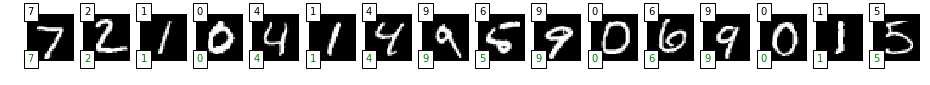

In [50]:
# plot 16 images as gray scale
nb_images = 16

predicted = model.predict(X_test[:nb_images]).argmax(-1)
truth = y_test[:nb_images].argmax(-1)

plt.figure(figsize=(16,8))
for i in range(nb_images):
    plt.subplot(1, nb_images, i+1)
    plt.imshow(X_test_all[i], interpolation='nearest',cmap=plt.get_cmap('gray'))
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.text(0, 28, truth[i], color='green', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

**Exercise**

* Modify this baseline model by adding more dense layers. Would you rather extend, or reduce, the number of hidden units? What activation function would you use?
* Change the batch size. What kind of tradeoff do you expect (slower/faster, more/less accurate) ?
* Try to improve the baseline results with your model. Check the training and validation accuracy, and beware of overfitting. 

## Simple Convolutional Neural Network for MNIST

Now that we have seen how to load the MNIST dataset and train a simple multi-layer perceptron model on it, it is time to develop a more sophisticated convolutional neural network or CNN model.

Keras does provide a lot of capability for [creating convolutional neural networks](http://keras.io/layers/convolutional).

In this section we will create a simple CNN for MNIST that demonstrates how to use all of the aspects of a modern CNN implementation, including Convolutional layers and Pooling layers.

The first step is to import the classes and functions needed.


In [73]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Again, we always initialize the random number generator to a constant seed value for reproducibility of results.

In [74]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Next we need to reshape the MNIST dataset so that it is suitable for use training a CNN. In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [pixels][width][height].

In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1.

In [90]:
# load data
X_train=X_train_all[0:2000]
y_train=y_train_all[0:2000]
X_test=X_test_all[0:1000]
y_test=y_test_all[0:1000]
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

As before, it is a good idea to normalize the pixel values to the range 0 and 1 and one hot encode the output variables.

In [91]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

Next we define our neural network model.

Convolutional neural networks are more complex than standard multi-layer perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state of the art results. Below summarizes the network architecture.

1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
2. Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
3. The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
4. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
5. Next a fully connected layer with 128 neurons and rectifier activation function.
6. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm.

In [92]:
def baseline_model():
    # create model
    model = Sequential()
    # Conv2D class parameters doc: https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    # MaxPooling doc: https://medium.com/@udemeudofia01/basic-overview-of-convolutional-neural-network-cnn-4fcc7dbb4f17
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Let us build the model.

In [93]:
# build the model
model = baseline_model()

**Exercise**

* Why was a 5*5 filter used in the convolutional layer? What other values could make sense?
* Why using a max pooling layer? What other values (2*2) could make sense?
* What is the number of parameters in this network? Come up with your estimate, and use the `model.summary()` function to check your result
* What is the layer with the most parameters?


In [88]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 24, 24)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               589952    
_________________________________________________________________
dense_29 (Dense)             (None, 10)                1290      
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
_________________________________________________________________


We evaluate the model the same way as before with the multi-layer perceptron. The CNN is fit over 10 epochs with a batch size of 100. We also use the `PlotLossesKeras()` function for plotting the accuracy metrics, instead of the text logs.

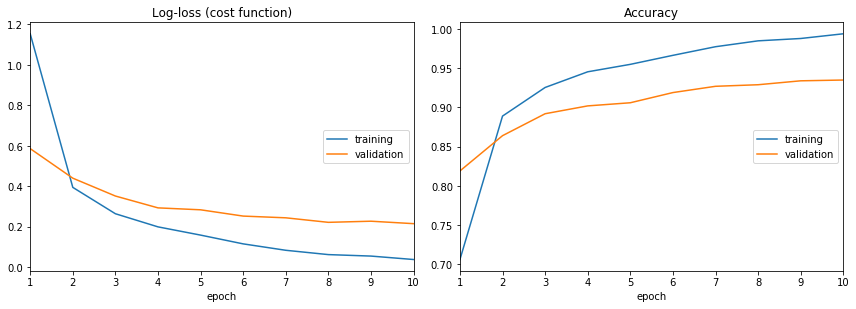

Log-loss (cost function):
training   (min:    0.038, max:    1.154, cur:    0.038)
validation (min:    0.215, max:    0.586, cur:    0.215)

Accuracy:
training   (min:    0.706, max:    0.994, cur:    0.994)
validation (min:    0.819, max:    0.935, cur:    0.935)
CNN Error: 6.50%


In [94]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100,callbacks=[PlotLossesKeras()])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Running the example, the accuracy on the training and validation test is printed for each epoch, and at the end of the classification, the error rate is printed.

Epochs may take about 5s seconds to run on the CPU. You can see that the network achieves an error rate of around 6/7%, which is better than our simple multi-layer perceptron model above.


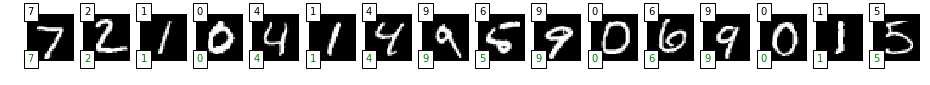

In [95]:
# plot 16 images as gray scale
nb_images = 16

predicted = model.predict(X_test[:nb_images]).argmax(-1)
truth = y_test[:nb_images].argmax(-1)

plt.figure(figsize=(16,8))
for i in range(nb_images):
    plt.subplot(1, nb_images, i+1)
    plt.imshow(X_test_all[i], interpolation='nearest',cmap=plt.get_cmap('gray'))
    plt.text(0, 0, predicted[i], color='black', 
             bbox=dict(facecolor='white', alpha=1))
    plt.text(0, 28, truth[i], color='green', 
             bbox=dict(facecolor='white', alpha=1))
    plt.axis('off')

Let us visualise predictions. Number on the top left corner (in black) are the predictions, and in the bottom left corner (in green) the true label.

# Larger Convolutional Neural Network for MNIST

Now that we have seen how to create a simple CNN, let’s take a look at a model capable of close to state of the art results. Let's re-initialize our setup (seed selection, data preparation, etc) similarly to how we did it in the previous CNN example.



In [96]:
# Larger CNN for the MNIST Dataset

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
X_train=X_train_all[0:2000]
y_train=y_train_all[0:2000]
X_test=X_test_all[0:1000]
y_test=y_test_all[0:1000]
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

This time we define a large CNN architecture with additional convolutional, max pooling layers and fully connected layers. The network topology can be summarized as follows.

1. Convolutional layer with 30 feature maps of size 5×5.
2. Pooling layer taking the max over 2*2 patches.
3. Convolutional layer with 15 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 20%.
6. Flatten layer.
7. Fully connected layer with 128 neurons and rectifier activation.
8. Fully connected layer with 50 neurons and rectifier activation.
9. Output layer.

In [123]:
# define the larger model

def larger_model():
    print("making model 1")
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), padding="same", input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

"""
# Don't hesitate to mess with this model; this is a crazy creative model made for your own exploration of parameters!
def larger_model():
    print("making model 2")
    # create model
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding="same", input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
"""


'\n# Don\'t hesitate to mess with this model; this is a crazy creative model made for your own exploration of parameters!\ndef larger_model():\n    print("making model 2")\n    # create model\n    model = Sequential()\n    model.add(Conv2D(16, (3, 3), padding="same", input_shape=(1, 28, 28), activation=\'relu\'))\n    model.add(MaxPooling2D(pool_size=(2, 2)))\n    model.add(Conv2D(32, (3, 3), padding="valid", activation=\'relu\'))\n    model.add(MaxPooling2D(pool_size=(2, 2)))\n    model.add(Dropout(0.2))\n    model.add(Flatten())\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dense(32, activation=\'relu\'))\n    model.add(Dense(num_classes, activation=\'softmax\'))\n    # Compile model\n    model.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    return model\n'

Like the previous two experiments, the model is fit over 10 epochs with a batch size of 100.

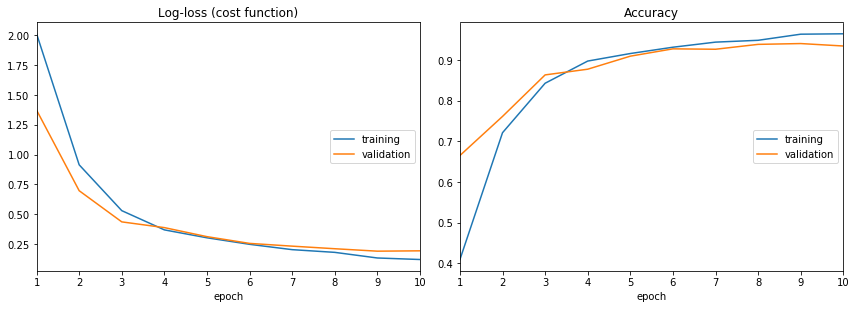

Log-loss (cost function):
training   (min:    0.121, max:    2.012, cur:    0.121)
validation (min:    0.191, max:    1.372, cur:    0.193)

Accuracy:
training   (min:    0.409, max:    0.964, cur:    0.964)
validation (min:    0.665, max:    0.940, cur:    0.934)
Large CNN Error: 6.60%


In [124]:
# build the model
model = larger_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, callbacks=[PlotLossesKeras()])
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))


** Exercises**

* To what extent was the accuracy improved - is that significant?
* Accuracies of more than 99% can be achieved on this dataset. What could you do to further improve the model accuracy?

## Additional material

### Understanding layer shapes

An important feature of Keras layers is that each of them has an `input_shape` attribute, which you can use to visualize the shape of the input tensor, and an `output_shape` attribute, for inspecting the shape of the output tensor.

As we can see, the input shape of the first convolutional layer corresponds to the `input_shape` attribute (which must be specified by the user). 

In this case, it is a `28x28` image with three color channels. 

Since this convolutional layer has the `padding` set to `same`, its output width and height will remain the same, and the number of output channel will be equal to the number of filters learned by the layer, 16. 

The following convolutional layer, instead, have the default `padding`, and therefore reduce width and height by $(k-1)$, where $k$ is the size of the kernel. 

`MaxPooling` layers, instead, reduce width and height of the input tensor, but keep the same number of channels. 

`Activation` layers, of course, don't change the shape.

In [30]:
for i, layer in enumerate(model.layers):
    print ("Layer", i, "\t", layer.name, "\t\t", layer.input_shape, "\t", layer.output_shape)

Layer 0 	 conv2d_2 		 (None, 1, 28, 28) 	 (None, 30, 24, 24)
Layer 1 	 max_pooling2d_2 		 (None, 30, 24, 24) 	 (None, 30, 12, 12)
Layer 2 	 conv2d_3 		 (None, 30, 12, 12) 	 (None, 15, 10, 10)
Layer 3 	 max_pooling2d_3 		 (None, 15, 10, 10) 	 (None, 15, 5, 5)
Layer 4 	 dropout_1 		 (None, 15, 5, 5) 	 (None, 15, 5, 5)
Layer 5 	 flatten_2 		 (None, 15, 5, 5) 	 (None, 375)
Layer 6 	 dense_5 		 (None, 375) 	 (None, 128)
Layer 7 	 dense_6 		 (None, 128) 	 (None, 50)
Layer 8 	 dense_7 		 (None, 50) 	 (None, 10)


### Understanding weights shape

In the same way, we can visualize the shape of the weights learned by each layer. 

In particular, Keras lets you inspect weights by using the `get_weights` method of a layer object. 

This will return a list with two elements, the first one being the **weight tensor** and the second one being the **bias vector**.

In particular:

- **MaxPooling layer** don't have any weight tensor, since they don't have learnable parameters. 


- **Convolutional layers**, instead, learn a $(k, k, n_i, n_o, )$ weight tensor, where $k$ is the size of the kernel (repeated), $n_i$ is the number of channels of the input tensor, and $n_o$ is the number of filters to be learned. 

For each of the $n_o$ filters, a bias is also learned. 


- **Dense layers** learn a $(n_i, n_o)$ weight tensor, where $n_o$ is the output size and $n_i$ is the input size of the layer. Each of the $n_o$ neurons also has a bias.

In [31]:
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        W, b = layer.get_weights()
        print("Layer", i, "\t", layer.name, "\t\t", W.shape, "\t", b.shape)

Layer 0 	 conv2d_2 		 (5, 5, 1, 30) 	 (30,)
Layer 2 	 conv2d_3 		 (3, 3, 30, 15) 	 (15,)
Layer 6 	 dense_5 		 (375, 128) 	 (128,)
Layer 7 	 dense_6 		 (128, 50) 	 (50,)
Layer 8 	 dense_7 		 (50, 10) 	 (10,)


## Acknowledgments

* https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/
* https://github.com/leriomaggio/deep-learning-keras-tensorflow/tree/master/4.%20Convolutional%20Neural%20Networks

## A Beginner's Guide To Understanding Convolutional Neural Networks 
https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/